# Exploration of Dandiset 001335: Neuropixels Recordings during Odor Presentation

**This notebook was AI-generated with `dandi-notebook-gen` and has not been fully verified. Please be cautious in interpreting code and results.**

It provides an introductory exploration of Dandiset [001335](https://dandiarchive.org/dandiset/001335/draft):

- **Name:** Neuropixels Recordings from Hippocampus of head-fixed mice during odor presentation
- **Description:** Recordings from hippocampus while mice exposed to odor sequences
- **Contributors:** Mohapatra, Manish; Halchenko, Yaroslav
- **Institution:** Dartmouth College, vandermeerlab
- **Created:** 2025-02-14
- **License:** CC-BY-4.0
- **Citation:** [see DANDI Archive](https://dandiarchive.org/dandiset/001335/draft)

This notebook demonstrates:
- How to access DANDI assets
- How to access and explore the NWB dataset contents
- Examples of visualizing Local Field Potentials (LFPs)
- Summarizing spike waveforms
- Plotting example raster of event-aligned unit spiking

--- 

## List all assets using DANDI API

In [1]:
from dandi.dandiapi import DandiAPIClient
client = DandiAPIClient()
dandiset = client.get_dandiset("001335")
assets = list(dandiset.get_assets())
for asset in assets:
    print(asset.path)

sub-M541/sub-M541_ecephys.nwb


## Loading the main NWB file
This code uses `lindi` + `pynwb` to remotely access the NWB data efficiently.

*Note:* No download of the entire NWB file is required.

In [2]:
import pynwb
import lindi

lindi_url = "https://lindi.neurosift.org/dandi/dandisets/001335/assets/aca66db7-4c02-4453-8dcb-a179d44b1c5d/nwb.lindi.json"
f = lindi.LindiH5pyFile.from_lindi_file(lindi_url)
nwb = pynwb.NWBHDF5IO(file=f, mode='r').read()

print("Session description:", nwb.session_description)
print("Identifier:", nwb.identifier)
print("Start time:", nwb.session_start_time)
print("Experimenter(s):", nwb.experimenter)

Session description: Block 1:UE (ABC), Block 2:SE (DEF), Block3:Localizer
Identifier: M541-2024-08-31
Start time: 2025-02-14 10:53:25.647928-05:00
Experimenter(s): ('Mohapatra, Manish',)


## Explore experimental intervals
Blocks and odors are annotated in the NWB file:

In [3]:
intervals = nwb.intervals
print("Available intervals:", list(intervals.keys()))
for k in intervals:
    print(f"{k}: {len(intervals[k]['id'])} entries")

Available intervals: ['Block 1', 'Block 2', 'Block 3', 'Odor A ON', 'Odor B ON', 'Odor C ON', 'Odor D ON', 'Odor E ON', 'Odor F ON']
Block 1: 1 entries
Block 2: 1 entries
Block 3: 1 entries
Odor A ON: 101 entries
Odor B ON: 101 entries
Odor C ON: 101 entries
Odor D ON: 101 entries
Odor E ON: 101 entries
Odor F ON: 101 entries


## Examine electrodes metadata

In [4]:
electrodes = nwb.electrodes
print("Number of electrodes:", len(electrodes['id'].data[:]))
print("Electrode columns:", electrodes.colnames)
print("Example locations:", electrodes['location'].data[:5])

Number of electrodes: 64
Electrode columns: ('location', 'group', 'group_name', 'label', 'depth', 'hemisphere')
Example locations: ['brain area' 'brain area' 'brain area' 'brain area' 'brain area']


## Access Local Field Potential (LFP) data

For illustration, we load and plot short snippets from selected channels.
*Note: LFP data are large; here we load a small subset.*

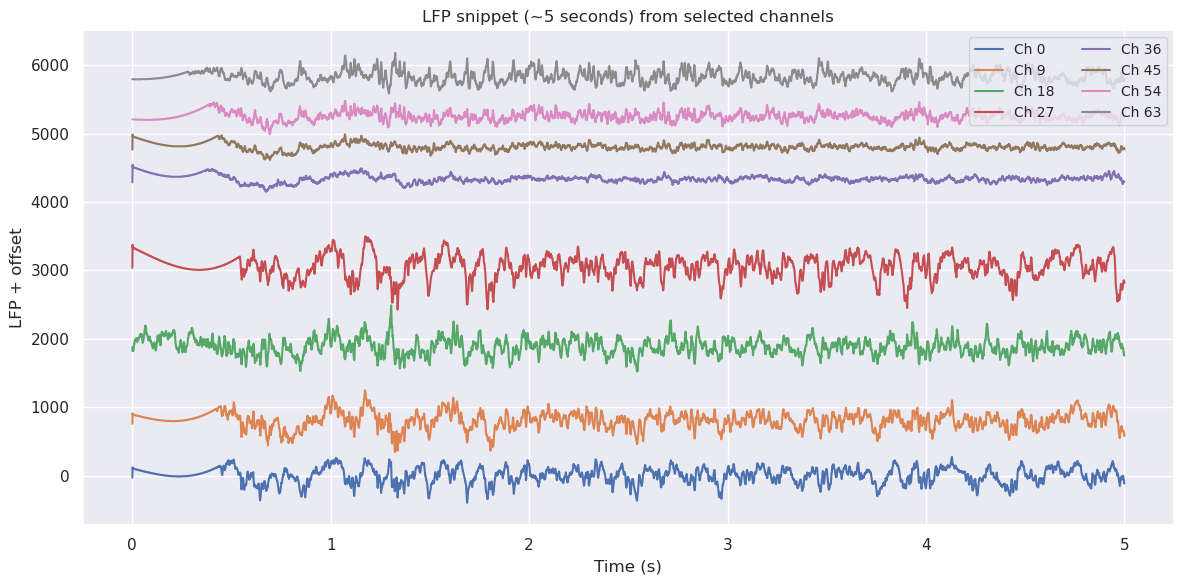

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_theme()

lfp = nwb.processing['ecephys']['LFP']
rate = lfp.rate
duration_sec = 5
n_samples = int(rate * duration_sec)

num_channels = lfp.data.shape[1]
channel_indices = np.linspace(0, num_channels - 1, 8, dtype=int)

snippet = lfp.data[:n_samples, :][:, channel_indices]

time = np.arange(n_samples) / rate

plt.figure(figsize=(12, 6))
offset = 0
for ch_idx in range(snippet.shape[1]):
    plt.plot(time, snippet[:, ch_idx] + offset, label=f'Ch {channel_indices[ch_idx]}')
    offset += np.ptp(snippet[:, ch_idx]) * 1.2
plt.xlabel('Time (s)')
plt.ylabel('LFP + offset')
plt.title('LFP snippet (~5 seconds) from selected channels')
plt.legend(fontsize='small', ncol=2, loc='upper right')
plt.tight_layout()
plt.show()

*The above figure shows clean LFP recordings with visible oscillatory activity across Neuropixels channels.*

## Examine spike waveforms from sorted units
We plot mean waveforms for a subset of units to illustrate the diversity of recorded spike shapes.

*Note: Full waveform arrays are subsampled here.*

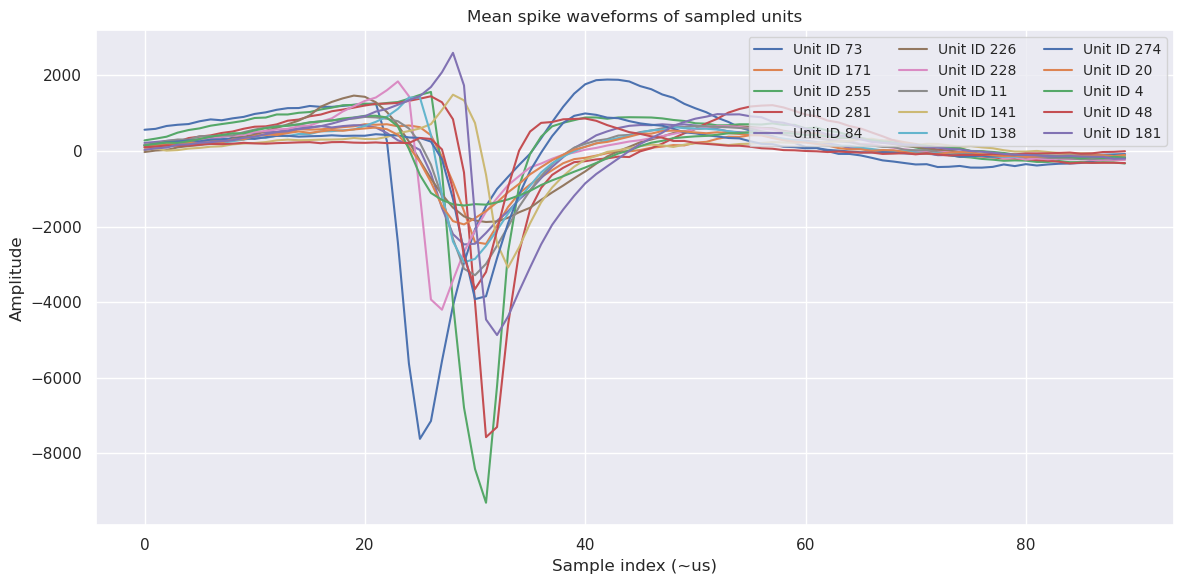

In [6]:
units = nwb.units

num_units = len(units['id'].data)
rng = np.random.default_rng(0)
indices = rng.choice(num_units, size=min(15, num_units), replace=False)

waveforms = units['waveform_mean'].data[indices]

plt.figure(figsize=(12, 6))
for i, idx in enumerate(indices):
    unit_id_val = units["id"].data[idx]
    plt.plot(waveforms[i], label=f'Unit ID {unit_id_val}')
plt.xlabel('Sample index (~us)')
plt.ylabel('Amplitude')
plt.title('Mean spike waveforms of sampled units')
plt.legend(fontsize='small', ncol=3, loc='upper right')
plt.tight_layout()
plt.show()

*The spike waveform plot above shows multiple diverse, well-resolved spike shapes.*

## Raster plot aligned to odor presentation events (Odor A)
This figure shows spike times relative to odor A onset across ~10 randomly chosen units.

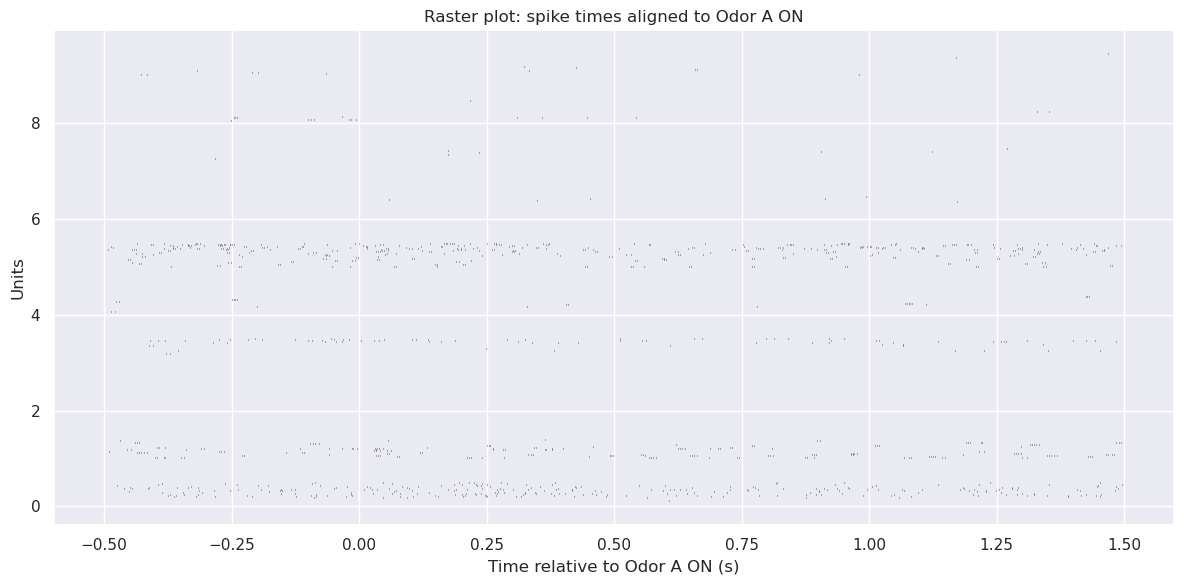

In [7]:
odorA = nwb.intervals['Odor A ON']
odor_starts = np.array(odorA['start_time'][:])

num_units = len(units['id'].data)
rng = np.random.default_rng(1)
indices = rng.choice(num_units, size=min(10, num_units), replace=False)

plt.figure(figsize=(12, 6))

for i, unit_idx in enumerate(indices):
    spike_times = units['spike_times'][unit_idx]
    for trial_idx, t0 in enumerate(odor_starts):
        t_start = t0 - 0.5
        t_end = t0 + 1.5
        ts = spike_times[(spike_times >= t_start) & (spike_times <= t_end)] - t0
        plt.vlines(ts, i + trial_idx / 200, i + (trial_idx + 1)/200, color='k', linewidth=0.5)

plt.xlabel('Time relative to Odor A ON (s)')
plt.ylabel('Units')
plt.title('Raster plot: spike times aligned to Odor A ON')
plt.tight_layout()
plt.show()

*Above raster visualization shows neural spiking aligned to odor presentation events, useful for investigating stimulus-locked activity patterns.*

## Summary

This notebook showcased:
- How to access information on a publicly available Dandiset via `dandi-api`
- Efficient loading of a large NWB neural recording file using `lindi` + `pynwb`
- How to access metadata, LFP signals, intervals of interest, and sorted units
- Example visualizations for LFP snippets, spike waveform means, and event-aligned raster plots

This provides a solid starting point for more advanced analyses involving this dataset, such as more detailed peri-stimulus time histograms (PSTHs), tuning analyses, or cross-channel correlations. Users should thoroughly validate these code samples before applying them to their work.